Reference: https://github.com/joosthub/PyTorchNLPBook/blob/master/chapters/chapter_6/classifying-surnames/Chapter-6-Surname-Classification-with-RNNs.ipynb

Given a surname, find the nationality. 

<img src="images/dataset.png">

# Imports

In [21]:
from argparse import Namespace 
from collections import Counter 
import json 
import os 
import string
import numpy as np 
import pandas as pd
import torch 
import torch.nn as nn 
import torch.optim as optim 
from torch.utils.data import Dataset, DataLoader 
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

# Vocabulary

In [22]:
class Vocabulary(object):
    def __init__(self, token_to_idx=None):
        """ token_to_idx (dict): a pre-existing map of tokens to indices """

        if token_to_idx is None:
            token_to_idx = {}
        self._token_to_idx = token_to_idx

        self._idx_to_token = {idx: token for token, idx in self._token_to_idx.items()}
        
    def to_serializable(self):
        return {'token_to_idx': self._token_to_idx}

    @classmethod
    def from_serializable(cls, contents):
        """ contents is a dict with keys token_to_idx, add_unk, and unk_token """
        return cls(**contents)

    def add_token(self, token):
        """ token: str """
        if token in self._token_to_idx:
            index = self._token_to_idx[token]
        else:
            index = len(self._token_to_idx)
            self._token_to_idx[token] = index
            self._idx_to_token[index] = token
        return index
    
    def lookup_token(self, token):
        return self._token_to_idx[token]

    def lookup_index(self, index):
        if index not in self._idx_to_token:
            raise KeyError("the index (%d) is not in the Vocabulary" % index)
        return self._idx_to_token[index]

    def __str__(self):
        return "<Vocabulary(size=%d)>" % len(self)

    def __len__(self):
        return len(self._token_to_idx)
    
    
class SequenceVocabulary(Vocabulary):
    def __init__(self, token_to_idx=None, unk_token="<UNK>", 
                 mask_token="<MASK>", begin_seq_token="<BEGIN>", end_seq_token="<END>"):
        
        super(SequenceVocabulary, self).__init__(token_to_idx)
        
        self._begin_seq_token = begin_seq_token
        self._end_seq_token = end_seq_token
        self._unk_token = unk_token
        self._mask_token = mask_token

        self.mask_index = self.add_token(self._mask_token)
        self.unk_index = self.add_token(self._unk_token) 
        self.begin_seq_index = self.add_token(self._begin_seq_token)
        self.end_seq_index = self.add_token(self._end_seq_token)
        
    def to_serializable(self):
        contents = super(SequenceVocabulary, self).to_serializable()
        contents.update({'unk_token': self._unk_token,
                         'mask_token': self._mask_token,
                         'begin_seq_token': self._begin_seq_token,
                         'end_seq_token': self._end_seq_token})
        return contents

    def lookup_token(self, token):
        """ token: str """
        if self.unk_index >= 0:
            return self._token_to_idx.get(token, self.unk_index)
        else:
            return self._token_to_idx[token]

# Vectorizer

In [23]:
class SurnameVectorizer(object):
    def __init__(self, char_vocab, nationality_vocab):
        """ inputs: Vocabulary objects """
        self.char_vocab = char_vocab
        self.nationality_vocab = nationality_vocab

    def vectorize(self, surname, vector_length=-1):
        indices = [self.char_vocab.begin_seq_index]
        indices.extend(self.char_vocab.lookup_token(token) for token in surname)
        indices.append(self.char_vocab.end_seq_index)
            
        if vector_length < 0:
            vector_length = len(indices)
            
        out_vector = np.zeros(vector_length, dtype=np.int64)
        out_vector[:len(indices)] = indices
        out_vector[len(indices):] = self.char_vocab.mask_index
        
        return out_vector, len(indices)
    
    @classmethod
    def from_dataframe(cls, surname_df):
        char_vocab = SequenceVocabulary()
        nationality_vocab = Vocabulary()
        
        for index, row in surname_df.iterrows():
            for char in row.surname:
                char_vocab.add_token(char)
            nationality_vocab.add_token(row.nationality)
        
        return cls(char_vocab, nationality_vocab)
    
    @classmethod
    def from_serializable(cls, contents):
        char_vocab = SequenceVocabulary.from_serializable(contents['char_vocab'])
        nationality_vocab = Vocabulary.from_serializable(contents['nationality_vocab'])
        return cls(char_vocab=char_vocab, nationality_vocab=nationality_vocab)

    def to_serializable(self):
        return {'char_vocab': self.char_vocab.to_serializable(),
                'nationality_vocab': self.nationality_vocab.to_serializable()}

# Dataset

In [24]:
class SurnameDataset(Dataset):
    def __init__(self, surname_df, vectorizer):
        self.surname_df = surname_df
        self._vectorizer = vectorizer

        self._max_seq_length = max(map(len, self.surname_df.surname)) + 2
        
        self.train_df = self.surname_df[self.surname_df.split=='train']
        self.train_size = len(self.train_df)

        self.val_df = self.surname_df[self.surname_df.split=='val']
        self.validation_size = len(self.val_df)

        self.test_df = self.surname_df[self.surname_df.split=='test']
        self.test_size = len(self.test_df)

        self._lookup_dict = {'train': (self.train_df, self.train_size),
                             'val': (self.val_df, self.validation_size),
                             'test': (self.test_df, self.test_size)}

        self.set_split('train')
        
        class_counts = surname_df.nationality.value_counts().to_dict()
        sorted_counts = sorted(class_counts.items(), \
                               key=lambda item: self._vectorizer.nationality_vocab.lookup_token(item[0]))
        frequencies = [count for _, count in sorted_counts]
        self.class_weights = 1.0 / torch.tensor(frequencies, dtype=torch.float32)

    @classmethod
    def load_dataset_and_make_vectorizer(cls, surname_csv):
        surname_df = pd.read_csv(surname_csv)
        train_surname_df = surname_df[surname_df.split=='train']
        return cls(surname_df, SurnameVectorizer.from_dataframe(train_surname_df))
    
    @classmethod
    def load_dataset_and_load_vectorizer(cls, surname_csv, vectorizer_filepath):
        surname_df = pd.read_csv(surname_csv)
        vectorizer = cls.load_vectorizer_only(vectorizer_filepath)
        return cls(surname_df, vectorizer)
    
    @staticmethod
    def load_vectorizer_only(vectorizer_filepath):
        with open(vectorizer_filepath) as fp:
            return SurnameVectorizer.from_serializable(json.load(fp))

    def save_vectorizer(self, vectorizer_filepath):
        with open(vectorizer_filepath, "w") as fp:
            json.dump(self._vectorizer.to_serializable(), fp)

    def get_vectorizer(self):
        return self._vectorizer
    
    def set_split(self, split="train"):
        self._target_split = split
        self._target_df, self._target_size = self._lookup_dict[split]

    def __len__(self):
        return self._target_size

    # used in generate_batches()
    def __getitem__(self, index):
        row = self._target_df.iloc[index]
        surname_vector, vec_length = self._vectorizer.vectorize(row.surname, self._max_seq_length)
        nationality_index = self._vectorizer.nationality_vocab.lookup_token(row.nationality)
        
        return {'x_data': surname_vector, 'y_target': nationality_index, 'x_length': vec_length}

    
    def get_num_batches(self, batch_size):
        return len(self) // batch_size

In [25]:
def generate_batches(dataset, batch_size, shuffle=True, drop_last=True, device="cpu"):
    dataloader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=shuffle, drop_last=drop_last)
    for data_dict in dataloader:
        out_data_dict = {}      
        for name, tensor in data_dict.items():
            out_data_dict[name] = data_dict[name].to(device)
        yield out_data_dict

# Model

In [26]:
def column_gather(y_out, x_lengths):
    # y_out.shape: (batch, seq, feature)
    # x_lengths.shape: (batch,)
    # output.shape: (batch, feature)
    # output contains the feature at the last time step
    x_lengths = x_lengths.long().detach().cpu().numpy() - 1
    out = []
    for batch_index, column_index in enumerate(x_lengths):
        out.append(y_out[batch_index, column_index])
        
    return torch.stack(out)


class ElmanRNN(nn.Module):
    # batch_first denotes the type of dimensions.
    # If first batch, we assume the shape of x_in and output is (batch_size, seq_size, feature_size).
    # If not, we assume the shape of x_in and output is (seq_size, batch_size, hidden_size).
    # When SurnameClassifier is called, batch_first=True is specified.
    # Thus in this example, we follow the format (batch_size, seq_size, feature_size).
    
    def __init__(self, input_size, hidden_size, batch_first=False):
        super(ElmanRNN, self).__init__()
        self.rnn_cell = nn.RNNCell(input_size, hidden_size)
        self.batch_first = batch_first
        self.hidden_size = hidden_size
        
    def _initial_hidden(self, batch_size):
        return torch.zeros((batch_size, self.hidden_size))
    
    def forward(self, x_in, initial_hidden=None):
        if self.batch_first:
            batch_size, seq_size, feat_size = x_in.size()
            x_in = x_in.permute(1, 0, 2)
        else:
            seq_size, batch_size, feat_size = x_in.size()
            
        hiddens = []
        
        if initial_hidden is None:
            initial_hidden = self._initial_hidden(batch_size)
            initial_hidden = initial_hidden.to(x_in.device)
            
        hidden_t = initial_hidden
        
        for t in range(seq_size):
            hidden_t = self.rnn_cell(x_in[t], hidden_t)
            hiddens.append(hidden_t)
            
        hiddens = torch.stack(hiddens)   # (seq_size, batch_size, hidden_size)
        
        if self.batch_first:
            hiddens = hiddens.permute(1, 0, 2)    # (batch_size, seq_size, hidden_size)
            
        return hiddens
    

# About x_lengths:
# When using a training dataset and a validation dataset, classifier() is called with x_lengths=None.
# In that case, the seq_size is a fixed number.
# But in the inference stage, the seq_size is not used. 
# See predict_nationality(). Given a surname, 
# 1) vectorized_surname, vec_length = vectorizer.vectorize(surname)
# 2) vec_length = torch.tensor([vec_length], dtype=torch.int64)
#    vectorized_surname = torch.tensor(vectorized_surname).unsqueeze(dim=0)
# 3) result = classifier(vectorized_surname, vec_length, apply_softmax=True)

class SurnameClassifier(nn.Module):
    def __init__(self, embedding_size, num_embeddings, num_classes, rnn_hidden_size, 
                 batch_first=True, padding_idx=0, dropout_p=0.5):
        
        super(SurnameClassifier, self).__init__()
        
        self.emb = nn.Embedding(embedding_dim=embedding_size, num_embeddings=num_embeddings, padding_idx=padding_idx)

        self.rnn = ElmanRNN(input_size=embedding_size, hidden_size=rnn_hidden_size, batch_first=batch_first)
        
        self.fc1 = nn.Linear(rnn_hidden_size, rnn_hidden_size)
        self.fc2 = nn.Linear(rnn_hidden_size, num_classes)
        
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, x_in, x_lengths=None, apply_softmax=False):
        # x_in.shape: (batch_size, seq_size)
        x_embedded = self.emb(x_in)   # (batch_size, seq_size, embedding_size)
        y_out = self.rnn(x_embedded)  # Assumg batch_first=True, y_out.shape is (batch_size, seq_size, hidden_size)
        
        if x_lengths is not None:     # used in prediction
            y_out = column_gather(y_out, x_lengths)
        else:                         # used on training and validation datasets
            y_out = y_out[:, -1, :]
        
        # y_out.shape: (batch_size, hidden_size)
        
        y_out = torch.relu(self.fc1(self.dropout(y_out)))
        y_out = self.fc2(self.dropout(y_out))

        if apply_softmax:
            y_out = torch.softmax(y_out, dim=1)

        return y_out   # (batch_size, num_classes)

# Helper functions

In [27]:
def make_train_state(args):
    return {'stop_early': False,
            'early_stopping_step': 0,
            'early_stopping_best_val': 1e8,
            'learning_rate': args.learning_rate,
            'epoch_index': 0,
            'train_loss': [],
            'train_acc': [],
            'val_loss': [],
            'val_acc': [],
            'test_loss': -1,
            'test_acc': -1,
            'model_filename': args.model_state_file}


# update_train_state() is called at the end of each epoch of the validation process.

def update_train_state(args, model, train_state):
    if train_state['epoch_index'] == 0:
        torch.save(model.state_dict(), train_state['model_filename'])
        train_state['stop_early'] = False
    else:
        loss_t = train_state['val_loss'][-1]

        if loss_t >= train_state['early_stopping_best_val']:
            train_state['early_stopping_step'] += 1
        else:
            torch.save(model.state_dict(), train_state['model_filename'])
            train_state['early_stopping_step'] = 0

        train_state['stop_early'] = train_state['early_stopping_step'] >= args.early_stopping_criteria

    return train_state


def compute_accuracy(y_pred, y_target):
    _, y_pred_indices = y_pred.max(dim=1)
    n_correct = torch.eq(y_pred_indices, y_target).sum().item()
    return n_correct / len(y_pred_indices) * 100

def set_seed_everywhere(seed, cuda):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if cuda:
        torch.cuda.manual_seed_all(seed)

def handle_dirs(dirpath):
    if not os.path.exists(dirpath):
        os.makedirs(dirpath)

# Settings

In [28]:
args = Namespace(
    # Data and Path information
    model_state_file='model.pth',
    surname_csv='../data/surnames_with_splits.csv',
    save_dir='model_storage/',
    vectorizer_file='vectorizer.json',
    # Model hyper parameters
    char_embedding_size=100,
    rnn_hidden_size=64,
    # Training hyper parameters
    batch_size=64,
    early_stopping_criteria=5,
    learning_rate=0.001,
    num_epochs=100,
    seed=1337,
    # Runtime options
    cuda=True,
    expand_filepaths_to_save_dir=True,
    reload_from_files=False,
)

if args.expand_filepaths_to_save_dir:
    args.vectorizer_file = os.path.join(args.save_dir, args.vectorizer_file)
    args.model_state_file = os.path.join(args.save_dir, args.model_state_file)
    
    print("Expanded filepaths: ")
    print("\t{}".format(args.vectorizer_file))
    print("\t{}".format(args.model_state_file))
    
if not torch.cuda.is_available():
    args.cuda = False

print("Using CUDA: {}".format(args.cuda))

args.device = torch.device("cuda" if args.cuda else "cpu")

# Set seed for reproducibility
set_seed_everywhere(args.seed, args.cuda)

# handle dirs
handle_dirs(args.save_dir)

Expanded filepaths: 
	model_storage/vectorizer.json
	model_storage/model.pth
Using CUDA: False


# Initialization

In [29]:
if args.reload_from_files:
    print("Loading dataset and vectorizer")
    dataset = SurnameDataset.load_dataset_and_load_vectorizer(args.surname_csv, args.vectorizer_file)
else:
    print("Loading dataset and creating vectorizer")
    dataset = SurnameDataset.load_dataset_and_make_vectorizer(args.surname_csv)
    dataset.save_vectorizer(args.vectorizer_file)    

vectorizer = dataset.get_vectorizer()
classifier = SurnameClassifier(embedding_size=args.char_embedding_size,
                               num_embeddings=len(vectorizer.char_vocab),
                               num_classes=len(vectorizer.nationality_vocab),
                               rnn_hidden_size=args.rnn_hidden_size,
                               padding_idx=vectorizer.char_vocab.mask_index)

Loading dataset and creating vectorizer


# Training loop

In [30]:
classifier = classifier.to(args.device)
dataset.class_weights = dataset.class_weights.to(args.device)

loss_func = nn.CrossEntropyLoss(dataset.class_weights)
optimizer = optim.Adam(classifier.parameters(), lr=args.learning_rate)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, mode='min', factor=0.5, patience=1)
# scheduler.step(train_state['val_loss'][-1]) is called at the end of each epoch of the validation process. 
# Then the scheduler adjusts the learning rate based on the latest validation loss.

train_state = make_train_state(args)

epoch_bar = tqdm(desc='training routine', total=args.num_epochs, position=0)

dataset.set_split('train')
train_bar = tqdm(desc='split=train', total=dataset.get_num_batches(args.batch_size), position=1, leave=True)

dataset.set_split('val')
val_bar = tqdm(desc='split=val', total=dataset.get_num_batches(args.batch_size), position=1, leave=True)

try:
    for epoch_index in range(args.num_epochs):
        train_state['epoch_index'] = epoch_index

        dataset.set_split('train')
        
        batch_generator = generate_batches(dataset, batch_size=args.batch_size, device=args.device)
        running_loss = 0.0
        running_acc = 0.0

        classifier.train()

        for batch_index, batch_dict in enumerate(batch_generator):
            optimizer.zero_grad()
            y_pred = classifier(x_in=batch_dict['x_data'])
            loss = loss_func(y_pred, batch_dict['y_target'])
            loss_t = loss.item()
            running_loss += (loss_t - running_loss) / (batch_index + 1)
            loss.backward()
            optimizer.step()
            
            acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
            running_acc += (acc_t - running_acc) / (batch_index + 1)

            train_bar.set_postfix(loss=running_loss, acc=running_acc, epoch=epoch_index)
            train_bar.update()

        train_state['train_loss'].append(running_loss)
        train_state['train_acc'].append(running_acc)

        dataset.set_split('val')
        
        batch_generator = generate_batches(dataset, batch_size=args.batch_size, device=args.device)
        running_loss = 0.
        running_acc = 0.

        classifier.eval()
        
        for batch_index, batch_dict in enumerate(batch_generator):
            y_pred = classifier(x_in=batch_dict['x_data'])
            loss = loss_func(y_pred, batch_dict['y_target'])
            loss_t = loss.item()
            running_loss += (loss_t - running_loss) / (batch_index + 1)

            acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
            running_acc += (acc_t - running_acc) / (batch_index + 1)
            
            val_bar.set_postfix(loss=running_loss, acc=running_acc, epoch=epoch_index)
            val_bar.update()

        train_state['val_loss'].append(running_loss)
        train_state['val_acc'].append(running_acc)

        train_state = update_train_state(args=args, model=classifier, train_state=train_state)

        if train_state['stop_early']:
            break
            
        scheduler.step(train_state['val_loss'][-1])
        train_bar.n = 0
        val_bar.n = 0
        
        epoch_bar.update()

except KeyboardInterrupt:
    print("Exiting loop")

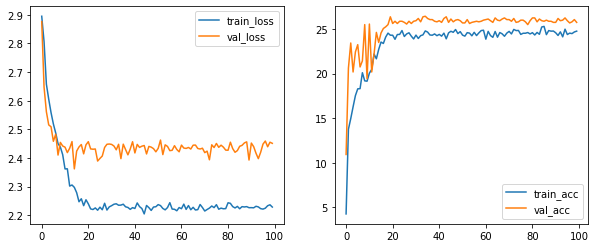

In [31]:
epochs = range(0, epoch_index+1)
fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(121)
ax.plot(epochs, train_state['train_loss'], label="train_loss")
ax.plot(epochs, train_state['val_loss'], label="val_loss")
ax.legend();

ax = fig.add_subplot(122)
ax.plot(epochs, train_state['train_acc'], label="train_acc")
ax.plot(epochs, train_state['val_acc'], label="val_acc")
ax.legend();

# Performance

In [32]:
classifier.load_state_dict(torch.load(train_state['model_filename']))
classifier = classifier.to(args.device)

dataset.class_weights = dataset.class_weights.to(args.device)
loss_func = nn.CrossEntropyLoss(dataset.class_weights)

dataset.set_split('test')
batch_generator = generate_batches(dataset, batch_size=args.batch_size, device=args.device)

running_loss = 0.
running_acc = 0.

classifier.eval()

for batch_index, batch_dict in enumerate(batch_generator):
    y_pred = classifier(x_in=batch_dict['x_data'])
    loss = loss_func(y_pred, batch_dict['y_target'])
    loss_t = loss.item()
    running_loss += (loss_t - running_loss) / (batch_index + 1)

    acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
    running_acc += (acc_t - running_acc) / (batch_index + 1)

train_state['test_loss'] = running_loss
train_state['test_acc'] = running_acc

print("Test loss: {:.3f}".format(train_state['test_loss']))
print("Test Accuracy: {:.2f}".format(train_state['test_acc']))

Test loss: 2.399
Test Accuracy: 26.00


# Inference

In [33]:
def predict_nationality(surname, classifier, vectorizer):
    vectorized_surname, vec_length = vectorizer.vectorize(surname)
    vectorized_surname = torch.tensor(vectorized_surname).unsqueeze(dim=0)
    vec_length = torch.tensor([vec_length], dtype=torch.int64)
    
    result = classifier(vectorized_surname, vec_length, apply_softmax=True)
    probability_values, indices = result.max(dim=1)
    index = indices.item()
    
    predicted_nationality = vectorizer.nationality_vocab.lookup_index(index)
    probability_value = probability_values.item()
    
    return {'nationality': predicted_nationality, 'probability': probability_value, 'surname': surname}

classifier = classifier.to("cpu")
for surname in ['McMahan', 'Nakamoto', 'Wan', 'Cho']:
    print(predict_nationality(surname, classifier, vectorizer))

{'nationality': 'Spanish', 'probability': 0.08245998620986938, 'surname': 'McMahan'}
{'nationality': 'Arabic', 'probability': 0.08361272513866425, 'surname': 'Nakamoto'}
{'nationality': 'Korean', 'probability': 0.10159873217344284, 'surname': 'Wan'}
{'nationality': 'Korean', 'probability': 0.07261434942483902, 'surname': 'Cho'}
